# Data Loading

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [2]:
fhv = pd.read_csv("fhv.csv")

In [3]:
print(fhv.shape)
fhv.head()

(12899039, 4)


,date,PUlocationID,DOlocationID,count
0,2015-01-01,0,0,10574
1,2015-01-03,0,0,13391
2,2015-01-04,0,0,13173
3,2015-01-13,0,0,21628
4,2015-01-15,0,0,24166


In [4]:
fhv.date.max(), fhv.date.min()

('2018-06-30', '2015-01-01')

In [5]:
_311 = pd.read_csv("311.csv")
_311 = _311[_311.Date >= "2015-01-01"][_311.Date <= "2018-06-30"]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [6]:
_311.head()

,Date,LocationID,Count
74381,2015-01-01,5,3
74382,2015-01-01,9,1
74383,2015-01-01,10,1
74384,2015-01-01,11,2
74385,2015-01-01,17,1


In [7]:
tickets = pd.read_csv("tickets.csv")

In [8]:
tickets.head()

,date,zone,pickup,dropoff,tickets
0,2015-01-01,0.0,13266.0,77789.0,0.0
1,2015-01-01,1.0,1.0,0.0,10.0
2,2015-01-01,2.0,3.0,0.0,75.0
3,2015-01-01,3.0,29.0,0.0,0.0
4,2015-01-01,4.0,455.0,0.0,43.0


# Analytics

## 1. FHV vs. 311

Text(0.5,1,'fhv vs. 311, total NYC * 1/1000')

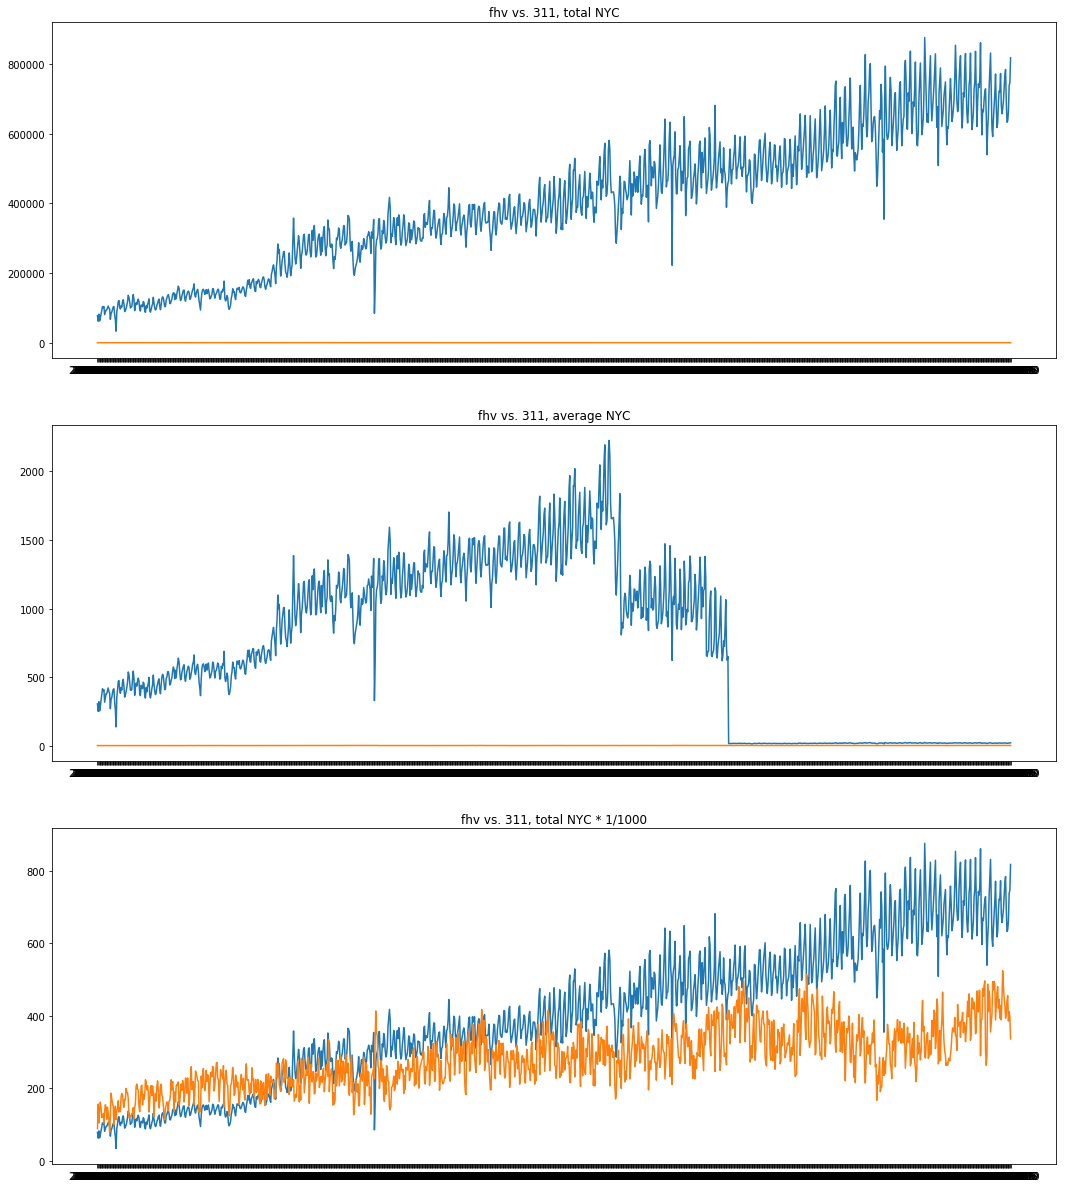

In [9]:
f = plt.figure(figsize=(18, 21))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)

ax1.plot(fhv[["date", "PUlocationID", "count"]].groupby("date").sum()["count"])
ax1.plot(_311.groupby("Date").sum()["Count"])
ax1.set_title("fhv vs. 311, total NYC")
ax2.plot(fhv[["date", "PUlocationID", "count"]].groupby("date").mean()["count"])
ax2.plot(_311.groupby("Date").mean()["Count"])
ax2.set_title("fhv vs. 311, average NYC")
ax3.plot(fhv[["date", "PUlocationID", "count"]].groupby("date").sum()["count"] / 1000)
ax3.plot(_311.groupby("Date").sum()["Count"])
ax3.set_title("fhv vs. 311, total NYC * 1/1000")

In [10]:
cycle_fhv, trend_fhv = sm.tsa.filters.hpfilter(fhv[["date", "PUlocationID", "count"]].groupby("date").sum()["count"], 
                                               1600)
cycle_311, trend_311 = sm.tsa.filters.hpfilter(_311.groupby("Date").sum()["Count"], 1600)

Text(0.5,1,'fhv vs. 311, total NYC * 1/1000, after HP filter')

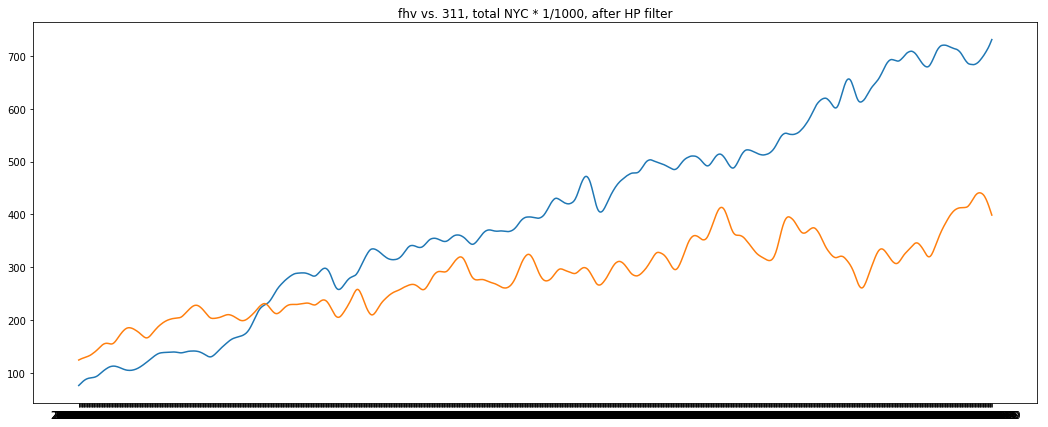

In [11]:
f = plt.figure(figsize=(18, 7))
ax1 = f.add_subplot(111)

ax1.plot(trend_fhv / 1000)
ax1.plot(trend_311)
ax1.set_title("fhv vs. 311, total NYC * 1/1000, after HP filter")

## 2. Corr of FHV vs. 311

### 2.1 All FHV vs. All 311

In [12]:
fhv_zone = fhv[fhv.PUlocationID >= 2][["date", "PUlocationID", "count"]].groupby("date").sum()["count"] / 1000
fhv_zone.head()

date
2015-01-01    64.522
2015-01-02    45.934
2015-01-03    65.645
2015-01-04    47.058
2015-01-05    49.017
Name: count, dtype: float64

In [13]:
_311_zone = _311.groupby("Date").sum()["Count"]
_311_zone.head()

Date
2015-01-01     88
2015-01-02    156
2015-01-03    104
2015-01-04    139
2015-01-05    161
Name: Count, dtype: int64

In [14]:
fhv_zone.corr(_311_zone)

0.67744694372363112

In [15]:
cycle_fhv, trend_fhv = sm.tsa.filters.hpfilter(fhv_zone, 1600)
cycle_311, trend_311 = sm.tsa.filters.hpfilter(_311_zone, 1600)

In [16]:
trend_fhv.corr(trend_311)

0.87235470322459296

Text(0.5,1,'Trends of correlations of 311 and FHV over months')

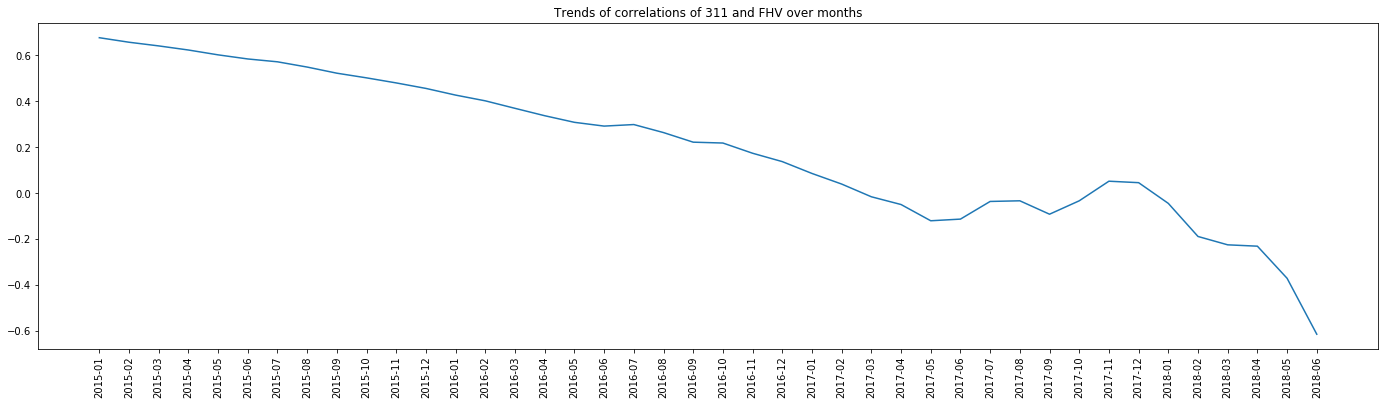

In [17]:
# Correlations over time intervals
months = fhv_zone.index.str[:7].unique()

corrs = []
for i, month in enumerate(months):
    corrs.append(fhv_zone[fhv_zone.index.str[:7].isin(months[i:])].
                 corr(_311_zone[_311_zone.index.str[:7].isin(months[i:])]))
f = plt.figure(figsize=(24, 6))
plt.xticks(rotation='vertical')
plt.plot(months, corrs)
plt.title("Trends of correlations of 311 and FHV over months")

Text(0.5,1,'2018-06')

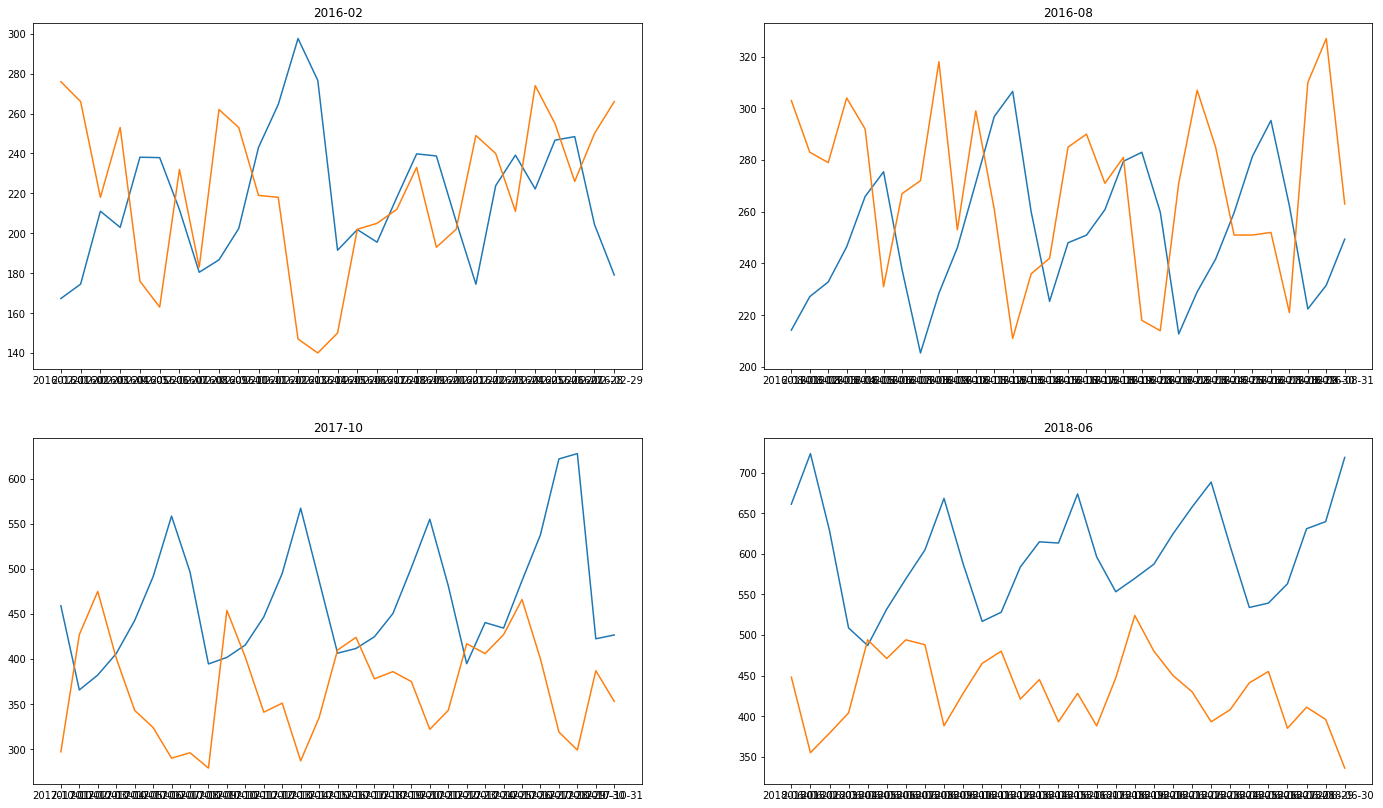

In [18]:
f = plt.figure(figsize=(24, 14))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.plot(fhv_zone[fhv_zone.index.str.startswith("2016-02")])
ax1.plot(_311_zone[_311_zone.index.str.startswith("2016-02")])
ax1.set_title("2016-02")
ax2.plot(fhv_zone[fhv_zone.index.str.startswith("2016-08")])
ax2.plot(_311_zone[_311_zone.index.str.startswith("2016-08")])
ax2.set_title("2016-08")
ax3.plot(fhv_zone[fhv_zone.index.str.startswith("2017-10")])
ax3.plot(_311_zone[_311_zone.index.str.startswith("2017-10")])
ax3.set_title("2017-10")
ax4.plot(fhv_zone[fhv_zone.index.str.startswith("2018-06")])
ax4.plot(_311_zone[_311_zone.index.str.startswith("2018-06")])
ax4.set_title("2018-06")

- In this four months, 311 and fhv are almost totally negative correlated

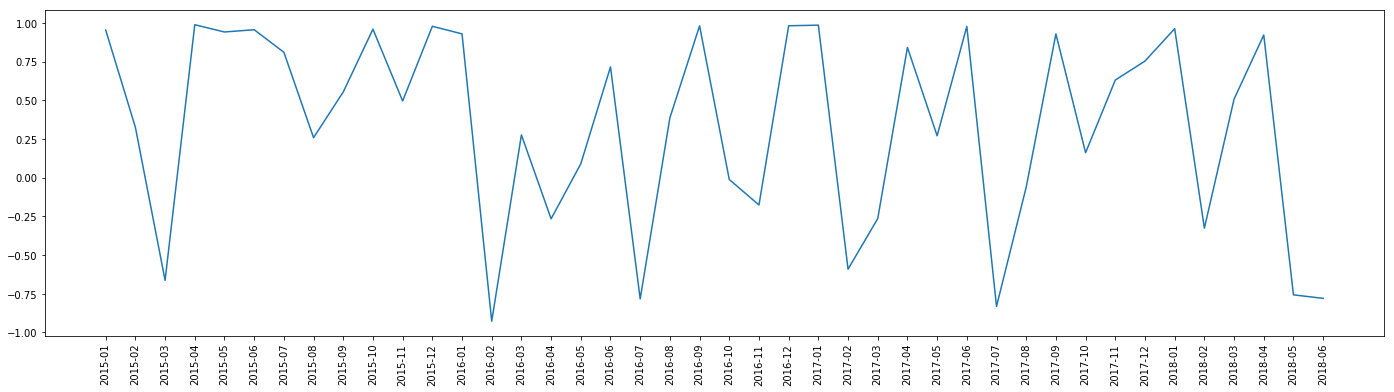

In [19]:
# Correlations over time intervals
months = trend_fhv.index.str[:7].unique()

corrs = []
for month in months:
    corrs.append(trend_fhv[trend_fhv.index.str.startswith(month)].corr(trend_311[trend_311.index.str.startswith(month)]))
f = plt.figure(figsize=(24, 6))
plt.xticks(rotation='vertical')
plt.plot(months, corrs)

Text(0.5,1,'2018-06')

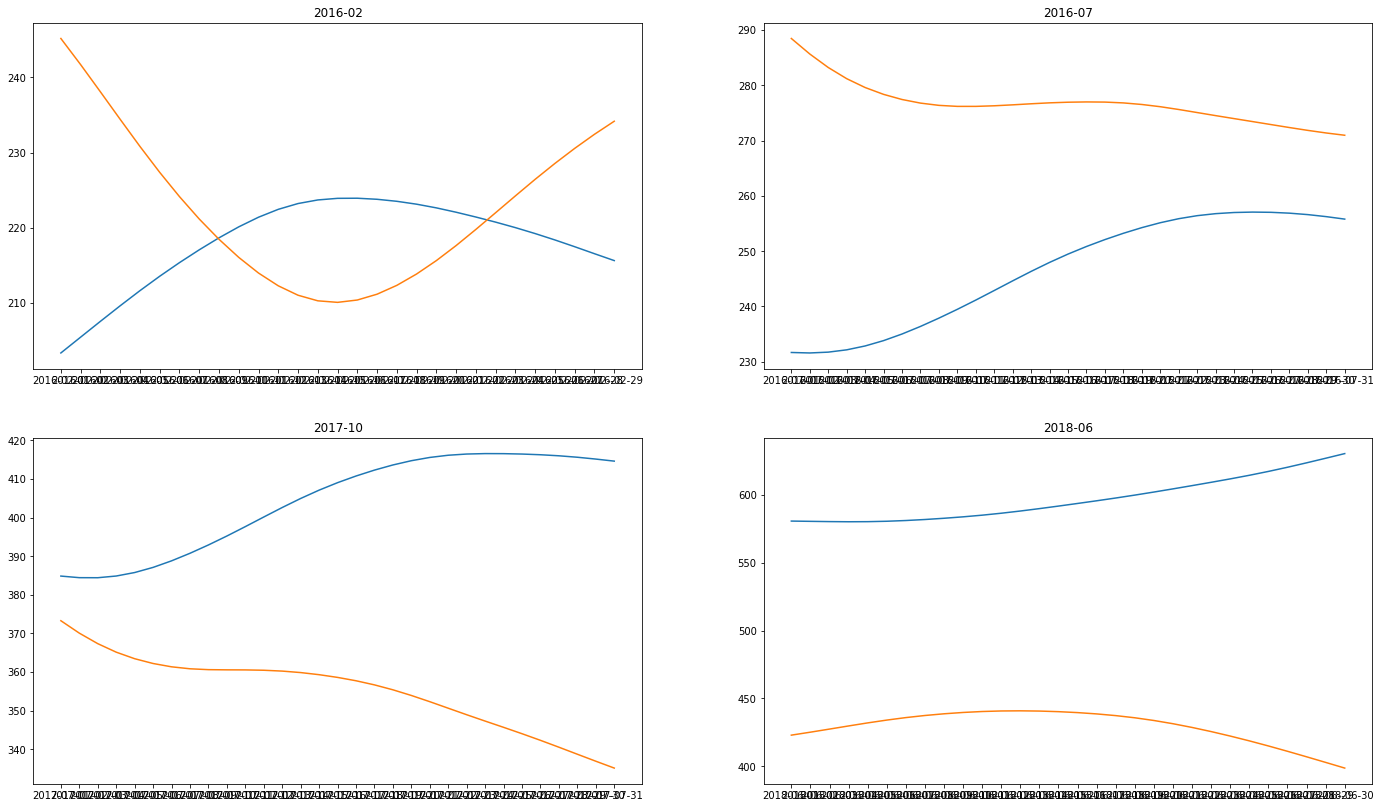

In [20]:
f = plt.figure(figsize=(24, 14))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.plot(trend_fhv[trend_fhv.index.str.startswith("2016-02")])
ax1.plot(trend_311[trend_311.index.str.startswith("2016-02")])
ax1.set_title("2016-02")
ax2.plot(trend_fhv[trend_fhv.index.str.startswith("2016-07")])
ax2.plot(trend_311[trend_311.index.str.startswith("2016-07")])
ax2.set_title("2016-07")
ax3.plot(trend_fhv[trend_fhv.index.str.startswith("2017-07")])
ax3.plot(trend_311[trend_311.index.str.startswith("2017-07")])
ax3.set_title("2017-10")
ax4.plot(trend_fhv[trend_fhv.index.str.startswith("2018-06")])
ax4.plot(trend_311[trend_311.index.str.startswith("2018-06")])
ax4.set_title("2018-06")

### 2.2 FHV vs. 311 in every zone

In [21]:
zoneids = range(2, 264)
res = {}

for zoneid in zoneids:
    fhv_zone = (fhv[fhv.PUlocationID == zoneid][["date", "PUlocationID", 
                                                 "count"]].groupby("date").sum()["count"] / 1000).reset_index()
    _311_zone = _311[_311.LocationID == zoneid].groupby("Date").sum()["Count"].reset_index()
    fhv_311 = _311_zone.merge(fhv_zone, left_on="Date", right_on="date")
    res[zoneid] = fhv_311.corr().iloc[0][1]

In [22]:
res

{2: nan,
 3: 0.18023731209871557,
 4: -0.030118931135267365,
 5: 0.16383118773778862,
 6: 0.022192207327512689,
 7: 0.19704501299841928,
 8: 0.092728553797812849,
 9: -0.049397812385591572,
 10: 0.19010455762329931,
 11: 0.39061023413375251,
 12: -0.21915648569130286,
 13: 0.33825865409034872,
 14: 0.25247564172896486,
 15: 0.18218391254731306,
 16: 0.030042658717941428,
 17: -0.07228562304983982,
 18: -0.035189282753249812,
 19: 0.10541898287792799,
 20: 0.2797778941471718,
 21: 0.64165672613556124,
 22: 0.5298605825677053,
 23: 0.10331418590716955,
 24: 0.15663977859571929,
 25: 0.19555881803461855,
 26: 0.066507344558594181,
 27: 0.34929973227445776,
 28: 0.09634775668329934,
 29: -0.03173880380446524,
 30: -0.06799226421364768,
 31: -0.15673607050906113,
 32: 0.064568598110224945,
 33: 0.063960836054832312,
 34: -0.032491607592485122,
 35: 0.083515922472112245,
 36: -0.035351330027549158,
 37: 0.079245166206757089,
 38: 0.18530792200847107,
 39: 0.33660246519561476,
 40: -0.1016748

In [23]:
nyctz = gpd.GeoDataFrame.from_file("Data/taxi_zones.shp")
nyctz_ft = nyctz.to_crs(epsg=4326)
nyctz_ft.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399991...
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...


In [24]:
corr = nyctz_ft.merge(pd.Series(res).reset_index().dropna(), left_on="LocationID", right_on="index")
corr.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index,0
0,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399991...,3,0.180237
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4,-0.030119
2,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5,0.163831
3,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,POLYGON ((-74.06367318899999 40.60219816599994...,6,0.022192
4,7,0.107417,0.000390,Astoria,7,Queens,POLYGON ((-73.90413637799996 40.76752031699986...,7,0.197045


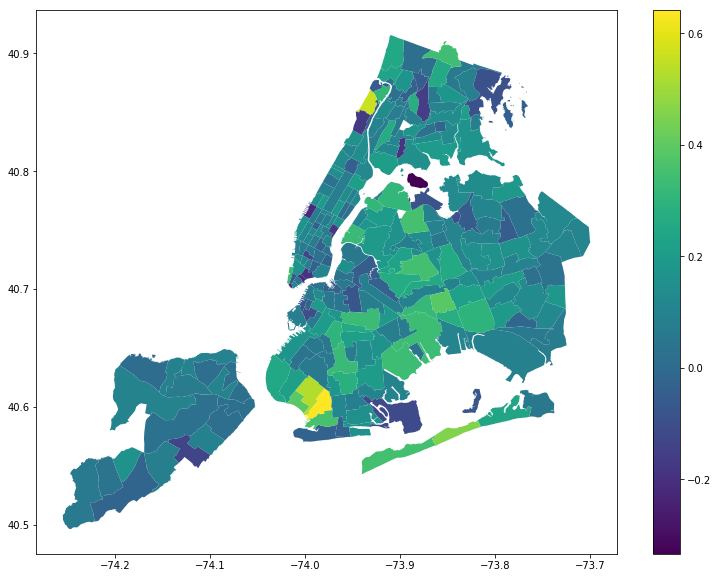

In [25]:
f = plt.figure(figsize=(13, 10))
ax = f.add_subplot(111)
corr.plot(column=0, ax=ax, legend=True)

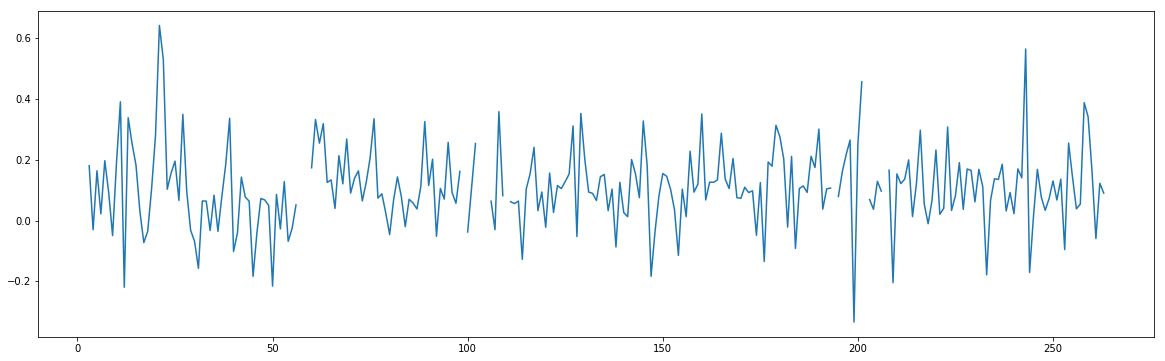

In [26]:
f = plt.figure(figsize=(20, 6))

plt.plot(res.keys(), res.values())

In [27]:
corr[corr.LocationID == 199]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index,0
189,199,0.077809,0.000289,Rikers Island,199,Bronx,POLYGON ((-73.88885148496314 40.79870632895875...,199,-0.333333


In [28]:
zoneids = range(2, 264)
res = {}

for zoneid in zoneids:
    try:
        fhv_zone = fhv[fhv.PUlocationID == zoneid][["date", "PUlocationID", 
                                                "count"]].groupby("date").sum()["count"] / 1000
        _311_zone = _311[_311.LocationID == zoneid].groupby("Date").sum()["Count"]
        cycle_fhv, trend_fhv = sm.tsa.filters.hpfilter(fhv_zone, 1600)
        cycle_311, trend_311 = sm.tsa.filters.hpfilter(_311_zone, 1600)
        fhv_311 = trend_311.reset_index().merge(trend_fhv.reset_index(), left_on="Date", right_on="date")
        res[zoneid] = fhv_311.corr().iloc[0][1]
    except:
        print(zoneid)

57
103
104
105


In [29]:
res

{2: -0.95956990315391089,
 3: 0.63242951831057592,
 4: -0.047765192977743183,
 5: 0.38978493553223642,
 6: 0.13442450653401439,
 7: 0.68735628649133584,
 8: 0.880738580548593,
 9: -0.33534198954090561,
 10: 0.58644802778943173,
 11: 0.77647048694610077,
 12: -0.88636573091406012,
 13: 0.49686859116558452,
 14: 0.51569496268243586,
 15: 0.64363684783559716,
 16: 0.12552980181253359,
 17: 0.042918072708272942,
 18: -0.14947591326502516,
 19: 0.37776972984232965,
 20: 0.79693677918737693,
 21: 0.92208558873694357,
 22: 0.87556490392222786,
 23: 0.39483874122708684,
 24: 0.35112711181854478,
 25: 0.51810140601403432,
 26: -0.22451477142823731,
 27: -0.018250702116191394,
 28: 0.34530674865726935,
 29: -0.15723003229129784,
 30: -0.29458769372974414,
 31: -0.52474354494664044,
 32: 0.27392809198168783,
 33: 0.30461558838924274,
 34: -0.19255460299108343,
 35: 0.41188965693307594,
 36: 0.15387303408931893,
 37: 0.63894023466519601,
 38: 0.70251313622123068,
 39: 0.74203631729753072,
 40: -0.

In [30]:
corr_hp = nyctz_ft.merge(pd.Series(res).reset_index().dropna(), left_on="LocationID", right_on="index")
corr_hp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index,0
0,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,2,-0.959570
1,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399991...,3,0.632430
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4,-0.047765
3,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5,0.389785
4,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,POLYGON ((-74.06367318899999 40.60219816599994...,6,0.134425


Text(0.5,1,'correlations of 311 vs. FHV in every zones, over HP filters')

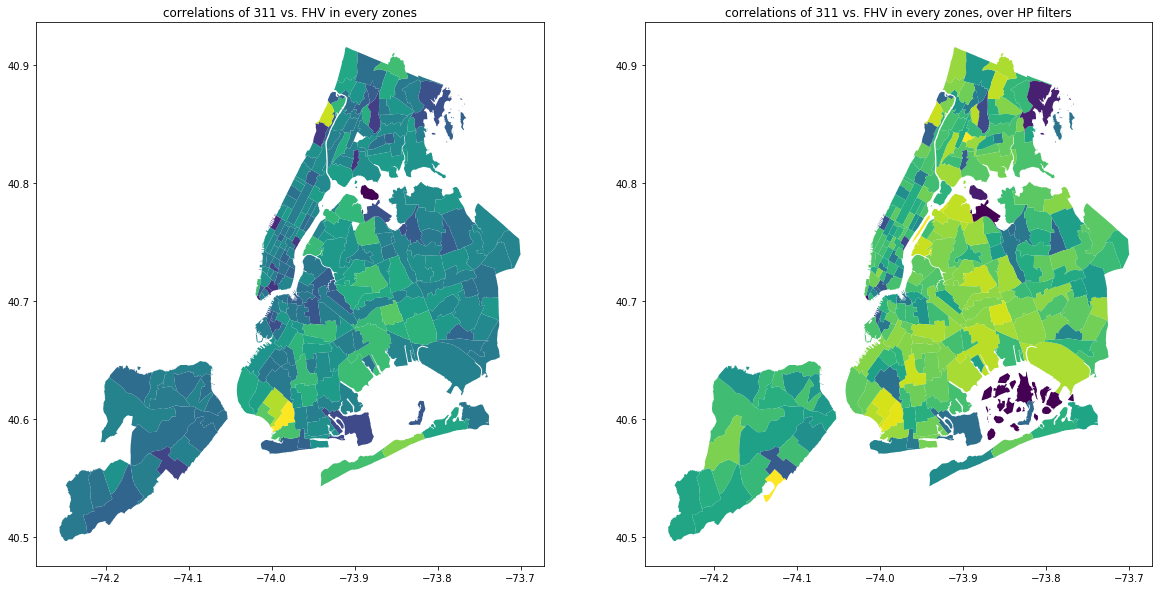

In [31]:
f = plt.figure(figsize=(20, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

corr.plot(column=0, ax=ax1)
ax1.set_title("correlations of 311 vs. FHV in every zones")
corr_hp.plot(column=0, ax=ax2)
ax2.set_title("correlations of 311 vs. FHV in every zones, over HP filters")

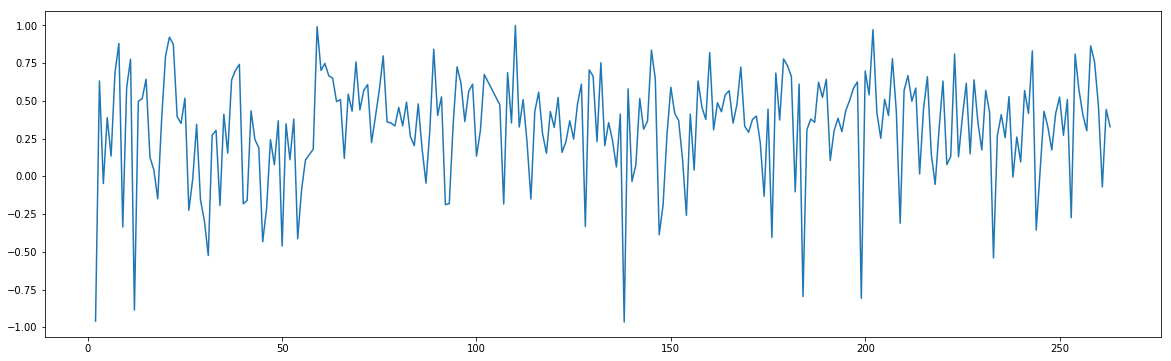

In [32]:
f = plt.figure(figsize=(20, 6))

plt.plot(res.keys(), res.values())

In [33]:
corr_hp[corr_hp.LocationID == 138]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index,0
133,138,0.107467,0.000537,LaGuardia Airport,138,Queens,(POLYGON ((-73.87124856242509 40.7860381512549...,138,-0.965115


# Modelling

## 1. Model on whole city

### 1.1 FHV vs. 311

In [34]:
fhv_zone = fhv[fhv.PUlocationID >= 2][["date", "PUlocationID", "count"]].groupby("date").sum()["count"] / 1000
_311_zone = _311.groupby("Date").sum()["Count"]

In [35]:
lineardata = pd.concat((_311_zone, fhv_zone), axis=1)
lineardata.head()

,Count,count
2015-01-01,88,64.522
2015-01-02,156,45.934
2015-01-03,104,65.645
2015-01-04,139,47.058
2015-01-05,161,49.017


In [36]:
train, test = train_test_split(lineardata, train_size = 0.7)

In [37]:
smols = smf.ols(formula='Count~count', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     778.9
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          1.15e-123
Time:                        09:12:25   Log-Likelihood:                -4938.3
No. Observations:                 893   AIC:                             9881.
Df Residuals:                     891   BIC:                             9890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    178.6520      4.336     41.205      0.000       170.143   187.161
count          0.3435      0.012     27.908      0.000         0.319     0.368
==============================================================================
Omnibus:                        5.191   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.084
Skew:                           0.182   Prob(JB):                       0.0787
Kurtosis:                       3.067   Cond. No.                         747.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

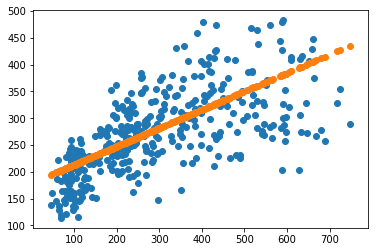

In [38]:
plt.scatter(test["count"], test["Count"])
plt.scatter(test["count"], smols.predict(test))

In [39]:
cycle_fhv, trend_fhv = sm.tsa.filters.hpfilter(fhv_zone, 1600)
cycle_311, trend_311 = sm.tsa.filters.hpfilter(_311_zone, 1600)

In [40]:
lineardata_hp = pd.concat((trend_311, trend_fhv), axis=1)
lineardata_hp.head()

,Count,count
2015-01-01,124.768825,58.539888
2015-01-02,125.454896,59.510215
2015-01-03,126.117987,60.484281
2015-01-04,126.754207,61.457340
2015-01-05,127.345843,62.427870


In [41]:
train_hp, test_hp = train_test_split(lineardata_hp, train_size = 0.7)

In [42]:
smols_hp = smf.ols(formula='Count~count', data=train_hp).fit()
smols_hp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     3084.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          1.41e-291
Time:                        09:12:25   Log-Likelihood:                -4400.7
No. Observations:                 893   AIC:                             8805.
Df Residuals:                     891   BIC:                             8815.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    165.2789      2.377     69.526      0.000       160.613   169.945
count          0.3827      0.007     55.534      0.000         0.369     0.396
==============================================================================
Omnibus:                        2.993   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                3.126
Skew:                          -0.059   Prob(JB):                        0.209
Kurtosis:                       3.265   Cond. No.                         733.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Linear Regression on 311 by using FHV data, over HP filters, R_2=0.759, Coef=[0.358, 0.385]')

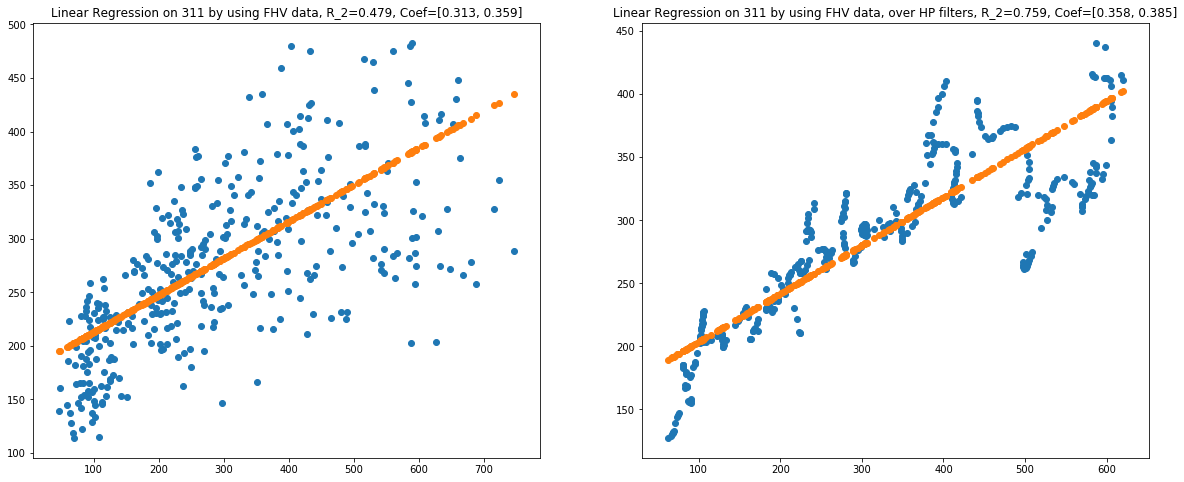

In [43]:
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.scatter(test["count"], test["Count"])
ax1.scatter(test["count"], smols.predict(test))
ax1.set_title("Linear Regression on 311 by using FHV data, R_2=0.479, Coef=[0.313, 0.359]")
ax2.scatter(test_hp["count"], test_hp["Count"])
ax2.scatter(test_hp["count"], smols_hp.predict(test_hp))
ax2.set_title("Linear Regression on 311 by using FHV data, over HP filters, R_2=0.759, Coef=[0.358, 0.385]")

### 1.2 FHV + Other variables vs. 311

In [44]:
date_range = pd.date_range('01/01/2015', '06/30/2018', freq='D')

In [49]:
# Weather

nycweather = pd.read_csv('nycweather_2014_2018.csv')[['DATE', 'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]
nycweather['TAVG'] = nycweather[['TMAX', 'TMIN']].mean(axis=1)
nycweather = nycweather[nycweather[nycweather['DATE']=='2015-01-01'].index[0] : nycweather[nycweather['DATE']=='2018-06-30'].index[0]+1]
nycweather.reset_index(drop=True, inplace=True)
nycweather = nycweather.sort_values('DATE')
nycweather.index = date_range
nycweather.drop(['TMAX', 'TMIN', 'DATE'], axis=1, inplace=True)
nycweather.columns = ['WindSpeed', 'Precipitation', 'Snow', 'Temperature']
print(nycweather.shape)
nycweather.head()

(1277, 4)


,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,7.16,0.00,0.0,33.0
2015-01-02,7.16,0.00,0.0,38.5
2015-01-03,6.49,0.71,0.0,37.5
2015-01-04,6.49,0.30,0.0,48.5
2015-01-05,10.51,0.00,0.0,35.0


In [51]:
# Holiday

# Generate a list of holidays over this period
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[len(date_range)-1])
holidays_all

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [52]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1277, 1)


,holidays
2015-01-01,0
2015-01-02,1
2015-01-03,0
2015-01-04,0
2015-01-05,0


In [53]:
# weekdays

holiday_date_list = holidays_all.date.tolist()
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1277, 1)


,weekdays
2015-01-01,1
2015-01-02,0
2015-01-03,1
2015-01-04,0
2015-01-05,0


In [54]:
lineardata = lineardata.merge(holidays, 
                              left_index=True, 
                              right_index=True).merge(weekdays, 
                                                      left_index=True, 
                                                      right_index=True).merge(nycweather, 
                                                                              left_index=True, 
                                                                              right_index=True)
lineardata.head()

,Count,count,holidays,weekdays,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,88,64.522,0,1,7.16,0.00,0.0,33.0
2015-01-02,156,45.934,1,0,7.16,0.00,0.0,38.5
2015-01-03,104,65.645,0,1,6.49,0.71,0.0,37.5
2015-01-04,139,47.058,0,0,6.49,0.30,0.0,48.5
2015-01-05,161,49.017,0,0,10.51,0.00,0.0,35.0


In [57]:
train, test = train_test_split(lineardata, train_size = 0.7)

In [58]:
smols = smf.ols(formula='Count~count+holidays+weekdays+WindSpeed+Precipitation+Snow+Temperature', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          1.53e-148
Time:                        09:15:11   Log-Likelihood:                -4821.8
No. Observations:                 887   AIC:                             9660.
Df Residuals:                     879   BIC:                             9698.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       122.7251     12.188     10.069      0.000        98.804   146.646
count             0.3435      0.011     30.621      0.000         0.321     0.366
holidays        -22.0961      8.501     -2.599      0.009       -38.781    -5.411
weekdays         -3.2461      4.217     -0.770      0.442       -11.522     5.030
WindSpeed        -1.1924      0.959     -1.244      0.214        -3.074     0.689
Precipitation   -28.5266      6.030     -4.731      0.000       -40.362   -16.691
Snow              1.9583      1.690      1.159      0.247        -1.359     5.275
Temperature       1.2026      0.130      9.225      0.000         0.947     1.458
==============================================================================
Omnibus:                        7.830   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.933
Skew:                           0.231   Prob(JB):                       0.0189
Kurtosis:                       2.966   Cond. No.                     2.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
lineardata_hp = lineardata_hp.merge(holidays, 
                              left_index=True, 
                              right_index=True).merge(weekdays, 
                                                      left_index=True, 
                                                      right_index=True).merge(nycweather, 
                                                                              left_index=True, 
                                                                              right_index=True)
lineardata_hp.head()

,Count,count,holidays,weekdays,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,124.768825,58.539888,0,1,7.16,0.00,0.0,33.0
2015-01-02,125.454896,59.510215,1,0,7.16,0.00,0.0,38.5
2015-01-03,126.117987,60.484281,0,1,6.49,0.71,0.0,37.5
2015-01-04,126.754207,61.457340,0,0,6.49,0.30,0.0,48.5
2015-01-05,127.345843,62.427870,0,0,10.51,0.00,0.0,35.0


In [60]:
train, test = train_test_split(lineardata_hp, train_size = 0.7)

In [61]:
smols = smf.ols(formula='Count~count+holidays+weekdays', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     942.4
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          1.59e-275
Time:                        09:15:40   Log-Likelihood:                -4417.8
No. Observations:                 893   AIC:                             8844.
Df Residuals:                     889   BIC:                             8863.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    168.0181      3.059     54.918      0.000       162.014   174.023
count          0.3754      0.007     53.025      0.000         0.362     0.389
holidays     -11.0008      5.247     -2.097      0.036       -21.299    -0.703
weekdays      -0.3044      2.526     -0.121      0.904        -5.261     4.652
==============================================================================
Omnibus:                        5.048   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.008
Skew:                          -0.147   Prob(JB):                       0.0817
Kurtosis:                       3.219   Cond. No.                     1.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1.3 FHV vs. tickets

In [85]:
fhv_zone = fhv[fhv.PUlocationID >= 2][["date", "PUlocationID", "count"]].groupby("date").sum()["count"]
tickets_zone = tickets.groupby("date").sum()["tickets"]

In [86]:
lineardata = pd.concat((tickets_zone, fhv_zone), axis=1)
lineardata.head()

,tickets,count
date,,
2015-01-01,5390.0,64522
2015-01-02,47811.0,45934
2015-01-03,24505.0,65645
2015-01-04,6834.0,47058
2015-01-05,55922.0,49017


In [87]:
train, test = train_test_split(lineardata, train_size = 0.7)

In [88]:
smols = smf.ols(formula='tickets~count', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tickets   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.055
Date:                Sat, 27 Apr 2019   Prob (F-statistic):              0.305
Time:                        12:28:46   Log-Likelihood:                -9743.3
No. Observations:                 893   AIC:                         1.949e+04
Df Residuals:                     891   BIC:                         1.950e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.144e+04    941.910     33.380      0.000      2.96e+04  3.33e+04
count         -0.0028      0.003     -1.027      0.305        -0.008     0.003
==============================================================================
Omnibus:                       13.260   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.680
Skew:                          -0.298   Prob(JB):                      0.00107
Kurtosis:                       2.889   Cond. No.                     7.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

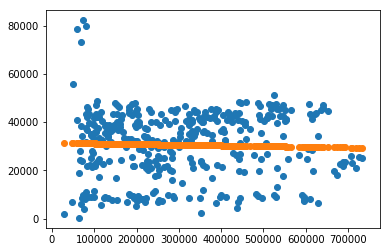

In [89]:
plt.scatter(test["count"], test["tickets"])
plt.scatter(test["count"], smols.predict(test))

In [90]:
cycle_fhv, trend_fhv = sm.tsa.filters.hpfilter(fhv_zone, 1600)
cycle_tikects, trend_tikects = sm.tsa.filters.hpfilter(tickets_zone, 1600)

In [91]:
lineardata_hp = pd.concat((trend_tikects, trend_fhv), axis=1)
lineardata_hp.head()

,tickets,count
date,,
2015-01-01,33014.937659,58539.887925
2015-01-02,35150.628280,59510.215089
2015-01-03,37269.053315,60484.281073
2015-01-04,39360.859910,61457.339563
2015-01-05,41408.717678,62427.869694


In [92]:
train_hp, test_hp = train_test_split(lineardata_hp, train_size = 0.7)

In [93]:
smols_hp = smf.ols(formula='tickets~count', data=train_hp).fit()
smols_hp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tickets   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.579
Date:                Sat, 27 Apr 2019   Prob (F-statistic):             0.0326
Time:                        12:28:50   Log-Likelihood:                -8791.3
No. Observations:                 893   AIC:                         1.759e+04
Df Residuals:                     891   BIC:                         1.760e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.014e+04    331.070     91.048      0.000      2.95e+04  3.08e+04
count          0.0020      0.001      2.140      0.033         0.000     0.004
==============================================================================
Omnibus:                      233.397   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1209.985
Skew:                           1.094   Prob(JB):                    1.80e-263
Kurtosis:                       8.266   Cond. No.                     7.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5,1,'Linear Regression on tickets by using FHV data, over HP filters, R_2=0.005, Coef=[0.000, 0.004]')

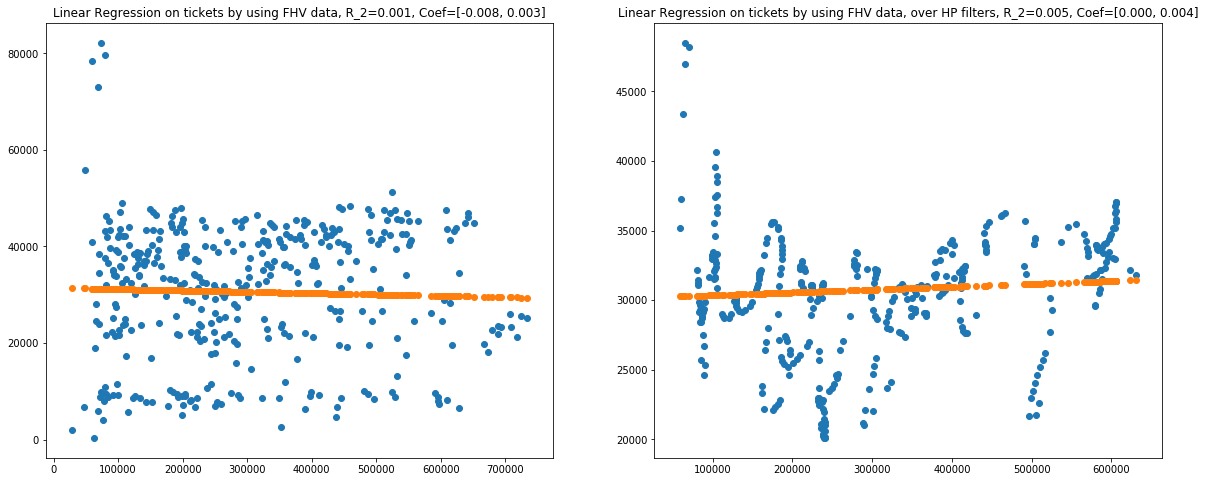

In [95]:
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.scatter(test["count"], test["tickets"])
ax1.scatter(test["count"], smols.predict(test))
ax1.set_title("Linear Regression on tickets by using FHV data, R_2=0.001, Coef=[-0.008, 0.003]")
ax2.scatter(test_hp["count"], test_hp["tickets"])
ax2.scatter(test_hp["count"], smols_hp.predict(test_hp))
ax2.set_title("Linear Regression on tickets by using FHV data, over HP filters, R_2=0.005, Coef=[0.000, 0.004]")

## 2. Model on every zone

### 2.1 FHV vs. 311

In [65]:
zoneids = range(2, 264)
_311_fhv = pd.DataFrame({"date": [], "Count": [], "count": [], "zone": []})

for zoneid in zoneids:
    fhv_zone = fhv[fhv.PUlocationID == zoneid][["date", "PUlocationID", 
                                                "count"]].groupby("date").sum()["count"].reset_index()
    _311_zone = _311[_311.LocationID == zoneid].groupby("Date").sum()["Count"].reset_index()
    fhv_311 = _311_zone.merge(fhv_zone, left_on="Date", right_on="date").drop("Date", axis=1)[["date", "Count", 
                                                                                               "count"]]
    fhv_311["zone"] = [zoneid] * len(fhv_311)
    _311_fhv = pd.concat((_311_fhv, fhv_311))
    
print(_311_fhv.shape)
_311_fhv.head()

(161327, 4)


,Count,count,date,zone
0,1.0,4.0,2015-09-14,2.0
1,1.0,8.0,2015-09-28,2.0
2,1.0,3.0,2015-09-29,2.0
3,1.0,2.0,2017-08-22,2.0
0,1.0,36.0,2015-01-09,3.0


In [66]:
_311_fhv = _311_fhv.reset_index().iloc[:, 1:]

In [67]:
lineardata = _311_fhv[["Count", "count"]]
lineardata.head()

,Count,count
0,1.0,4.0
1,1.0,8.0
2,1.0,3.0
3,1.0,2.0
4,1.0,36.0


In [68]:
train, test = train_test_split(lineardata, train_size = 0.7)

In [69]:
smols = smf.ols(formula='Count~count', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     514.0
Date:                Tue, 23 Apr 2019   Prob (F-statistic):          1.56e-113
Time:                        17:34:58   Log-Likelihood:            -2.3038e+05
No. Observations:              112928   AIC:                         4.608e+05
Df Residuals:                  112926   BIC:                         4.608e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.1199      0.007    294.585      0.000         2.106     2.134
count       7.935e-05    3.5e-06     22.671      0.000      7.25e-05  8.62e-05
==============================================================================
Omnibus:                    74358.771   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1264757.320
Skew:                           2.948   Prob(JB):                         0.00
Kurtosis:                      18.298   Cond. No.                     2.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

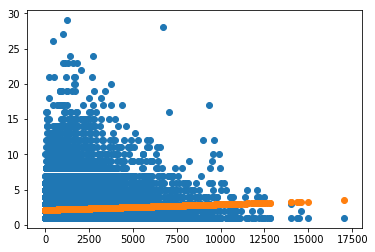

In [70]:
plt.scatter(test["count"], test["Count"])
plt.scatter(test["count"], smols.predict(test))

### 2.2 FHV vs. tikects

In [71]:
zoneids = range(2, 264)
tickets_fhv = pd.DataFrame({"date": [], "tickets": [], "count": [], "zone": []})

for zoneid in zoneids:
    fhv_zone = fhv[fhv.PUlocationID == zoneid][["date", "PUlocationID", 
                                                "count"]].groupby("date").sum()["count"].reset_index()
    tickets_zone = tickets[tickets.zone == zoneid].groupby("date").sum()["tickets"].reset_index()
    fhv_tickets = tickets_zone.merge(fhv_zone, on="date")[["date", "tickets", "count"]]
    fhv_tickets["zone"] = [zoneid] * len(fhv_tickets)
    tickets_fhv = pd.concat((tickets_fhv, fhv_tickets))
    
print(tickets_fhv.shape)
tickets_fhv.head()

(326566, 4)


,count,date,tickets,zone
0,3.0,2015-01-01,75.0,2.0
1,6.0,2015-01-02,179.0,2.0
2,5.0,2015-01-03,94.0,2.0
3,2.0,2015-01-04,52.0,2.0
4,4.0,2015-01-05,208.0,2.0


In [72]:
tickets_fhv = tickets_fhv.reset_index().iloc[:, 1:]

In [73]:
lineardata = tickets_fhv[["tickets", "count"]]
lineardata.head()

,tickets,count
0,75.0,3.0
1,179.0,6.0
2,94.0,5.0
3,52.0,2.0
4,208.0,4.0


In [74]:
train, test = train_test_split(lineardata, train_size = 0.7)

In [75]:
smols = smf.ols(formula='tickets~count', data=train).fit()
smols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tickets   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     633.4
Date:                Tue, 23 Apr 2019   Prob (F-statistic):          1.41e-139
Time:                        17:35:12   Log-Likelihood:            -1.4685e+06
No. Observations:              228596   AIC:                         2.937e+06
Df Residuals:                  228594   BIC:                         2.937e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    112.5768      0.389    289.662      0.000       111.815   113.339
count          0.0049      0.000     25.167      0.000         0.004     0.005
==============================================================================
Omnibus:                   130056.395   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1251847.397
Skew:                           2.618   Prob(JB):                         0.00
Kurtosis:                      13.198   Cond. No.                     2.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

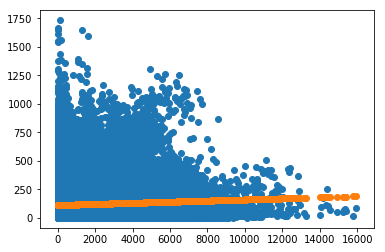

In [76]:
plt.scatter(test["count"], test["tickets"])
plt.scatter(test["count"], smols.predict(test))